# Imports

In [1]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 71.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 95.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.7/832.7 kB 76.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 117.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 96.2 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [dtw-python]1 [matplotlib]n]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtw import dtw

from abba import ABBA, ABBA_like, ABBAPatched
from models.LSTM import TimeSeriesLSTM
from train_LSTM import train_lstm
from models.ABBA_LSTM import ABBALSTM
from train_ABBALSTM import train_abba

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def resample_to_horizon(signal, horizon):
    x_old = np.linspace(0, 1, len(signal))
    x_new = np.linspace(0, 1, horizon)
    f = interp1d(x_old, signal, kind="linear")
    return f(x_new)

# Sin wave tests

## ABBA transformation and reconstruction

In [2]:
np.random.seed(42)
torch.manual_seed(42)

N = 200
t = np.linspace(0, 20, N)
series = np.sin(t) + 0.1 * np.random.randn(N)

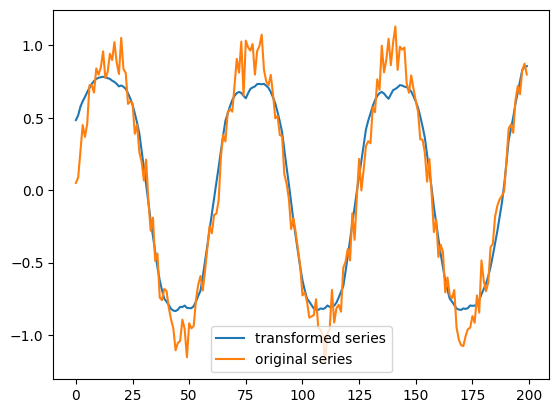

In [3]:
n_symbols = 12
window_size = 20

abba_like = ABBA_like(n_symbols=n_symbols, window_size=window_size)
symbol_sequence = abba_like.fit(series)
recon_smooth = abba_like.inverse_transform_smooth(symbol_sequence)
plt.plot(recon_smooth, label='transformed series')
plt.plot(series, label='original series')
plt.legend(loc='best')

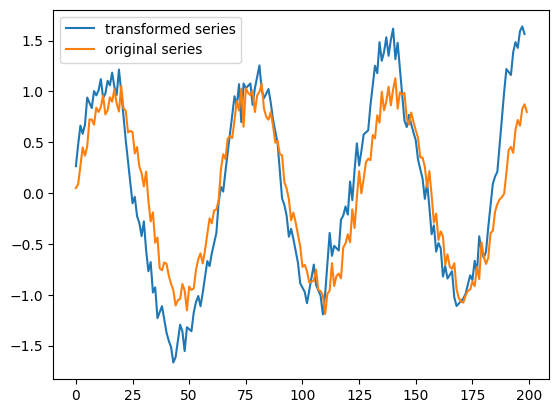

In [4]:
abba = ABBA()
symbol_sequence = abba.fit(series)
recon = abba.inverse_transform(symbol_sequence, series[0])
plt.plot(recon, label='transformed series')
plt.plot(series, label='original series')
plt.legend(loc='best')

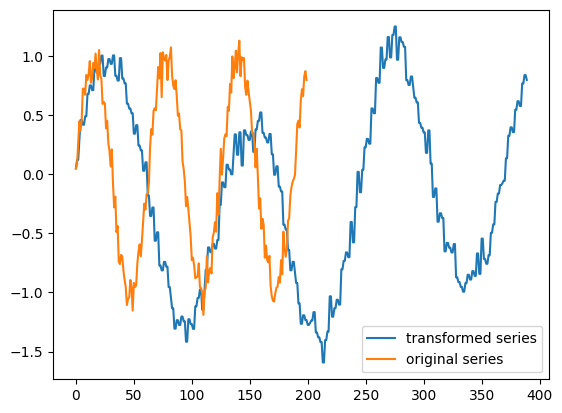

In [5]:
abba_patched = ABBAPatched()
symbol_sequence = abba_patched.fit(series)
recon_patched = abba_patched.inverse_transform(symbol_sequence, series[0])
plt.plot(recon_patched, label='transformed series')
plt.plot(series, label='original series')
plt.legend(loc='best')

## LSTM Prediction

In [6]:
model = TimeSeriesLSTM()
train_lstm(model, series, device='cuda')

/home/onyxia/work/ABBA_LSTM/utils/data_handler.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(X).unsqueeze(-1)


Epoch [10/200] Train: 0.127498 Val: 0.148393
Epoch [20/200] Train: 0.059735 Val: 0.058842
Epoch [30/200] Train: 0.014024 Val: 0.012130
Epoch [40/200] Train: 0.012531 Val: 0.011384
Epoch [50/200] Train: 0.012389 Val: 0.011305
Epoch [60/200] Train: 0.012289 Val: 0.011277
Epoch [70/200] Train: 0.012187 Val: 0.011235
Epoch [80/200] Train: 0.012084 Val: 0.011156
Epoch [90/200] Train: 0.011984 Val: 0.011064
Epoch [100/200] Train: 0.011876 Val: 0.011099
Early stopping à l'epoch 109 (best val loss = 0.011021)


In [7]:
lag=10
initial_series = torch.tensor(series, dtype=torch.float)  # batch=1
forecast = model.forecast(initial_series, horizon=20)

/tmp/ipykernel_21030/3278125454.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  forecast = np.array(forecast)


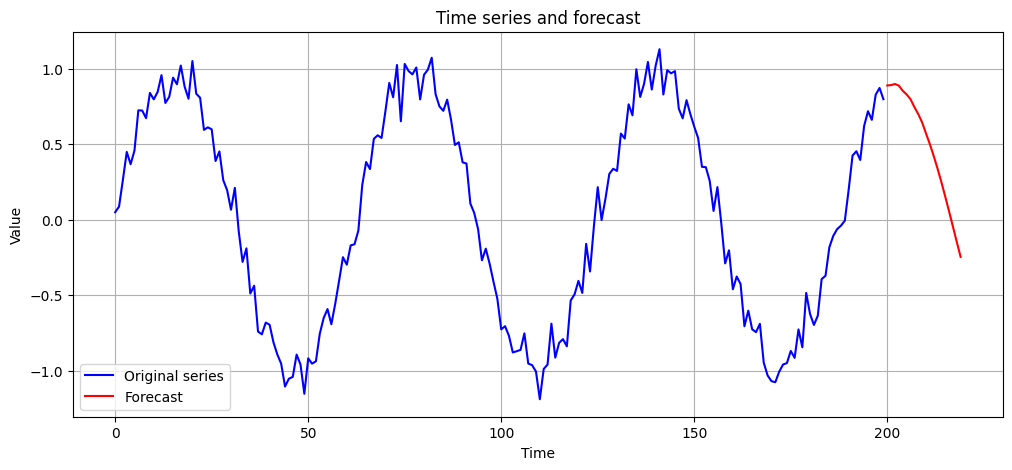

In [8]:
series = np.array(series)
forecast = np.array(forecast)

N = len(series)
H = len(forecast)

plt.figure(figsize=(12, 5))

plt.plot(range(N), series, label="Original series", color="blue")
plt.plot(range(N, N + H), forecast, label="Forecast", color="red")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time series and forecast")
plt.legend()
plt.grid(True)

plt.show()

## ABBA-LSTM Prediction

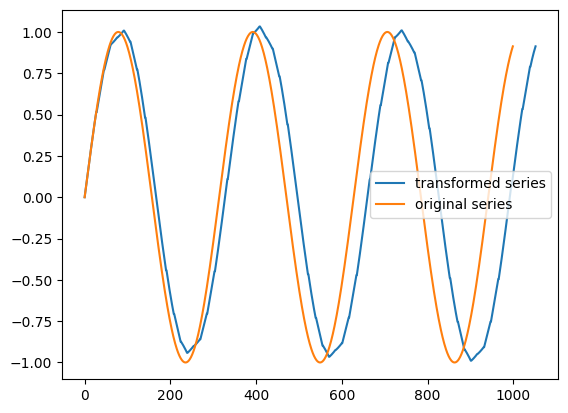

In [28]:
np.random.seed(42)
torch.manual_seed(42)

N = 1000
t = np.linspace(0, 20, N)
series = np.sin(t)

abba_patched = ABBAPatched()
symbol_sequence = abba_patched.fit(series)
recon_patched = abba_patched.inverse_transform(symbol_sequence, series[0])
plt.plot(recon_patched, label='transformed series')
plt.plot(series, label='original series')
plt.legend(loc='best')

In [29]:
n_symbols = len(abba_patched.patches.keys())
lag = 5
model = ABBALSTM(n_symbols, embedding_dim=63, hidden_sizes=[50, 50], lag=lag)
train_abba(model, symbol_sequence, device='cuda')

Epoch [10/200] Train: 2.376775 Val: 2.847672
Early stopping à l'epoch 16 (best val loss = 2.772314)


In [30]:
symbols_forecast = model.forecast(
    torch.tensor(symbol_sequence, dtype=torch.long),  # torch.LongTensor (lag,)
    horizon=10
)
symbols_forecast

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [31]:
numeric_forecast = abba.inverse_transform(symbols_forecast, series[-1])
numeric_forecast

array([ 0.67316908,  0.43339291,  0.19361674, -0.04615943, -0.28593559,
       -0.52571176, -0.76548793, -1.0052641 , -1.24504027, -1.48481644,
       -1.72459261, -1.96436878, -2.20414495, -2.44392112, -2.68369728,
       -2.92347345, -3.16324962, -3.40302579, -3.64280196, -3.88257813])

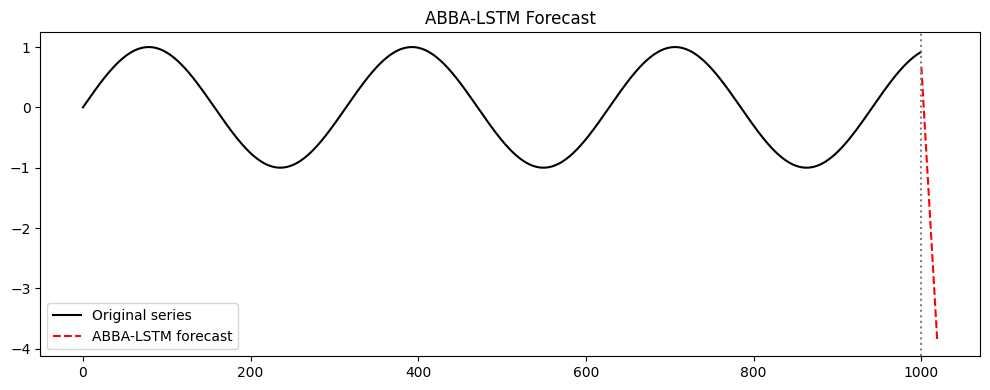

In [32]:
plt.figure(figsize=(10, 4))

# Série originale
plt.plot(
    np.arange(len(series)),
    series,
    label="Original series",
    color="black"
)

# Forecast
plt.plot(
    np.arange(len(series), len(series) + len(numeric_forecast)),
    numeric_forecast,
    label="ABBA-LSTM forecast",
    color="red",
    linestyle="--"
)

plt.axvline(len(series), color="gray", linestyle=":")
plt.legend()
plt.title("ABBA-LSTM Forecast")
plt.tight_layout()
plt.show()

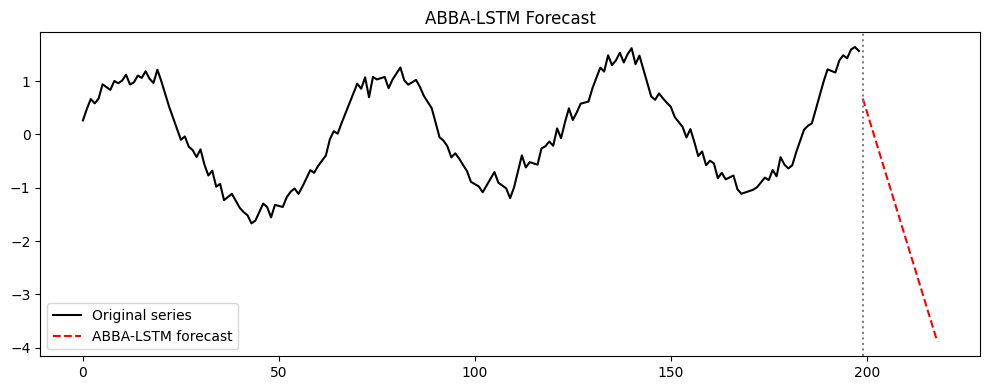

In [33]:
plt.figure(figsize=(10, 4))

# Série originale
plt.plot(
    np.arange(len(recon)),
    recon,
    label="Original series",
    color="black"
)

# Forecast
plt.plot(
    np.arange(len(recon), len(recon) + len(numeric_forecast)),
    numeric_forecast,
    label="ABBA-LSTM forecast",
    color="red",
    linestyle="--"
)

plt.axvline(len(recon), color="gray", linestyle=":")
plt.legend()
plt.title("ABBA-LSTM Forecast")
plt.tight_layout()
plt.show()

# Figure 10

In [10]:
N = 1000
frequencies = range(1, 101)
c = 50
n_layers = 2
lag_lstm = 50
lag_abba = 5
p = 50
lr = 0.001
horizon = 200
stateful = False
# tol = 0.1 * np.sqrt(horizon)
tol = 0.01

In [11]:
dtw_abba = []
dtw_lstm = []

for n in frequencies:
    for _ in range(1):
        print("n =", n)
        series = np.sin(2 * np.pi * n / N * np.arange(1, N + 1))
        t_future = np.arange(N + 1, N + horizon + 1)
        expected = np.sin(2 * np.pi * n / N * t_future)

        abba_patched = ABBAPatched(compression_tol=tol, alpha=0.01)
        symbol_sequence = abba_patched.fit(series)
        n_symbols = len(abba_patched.patches.keys())
        abba_model = ABBALSTM(n_symbols=n_symbols, hidden_sizes=[c]*n_layers, lag=lag_abba, stateful=stateful)
        train_abba(abba_model, symbol_sequence, epochs=500, lr=lr, patience=p, device="cuda")
        horizon_scaled = int(np.floor(horizon / np.mean(abba_patched.lengths)))
        abba_forecast = abba_model.forecast(torch.tensor(symbol_sequence[-lag_abba:], dtype=torch.long), horizon=horizon_scaled)
        abba_forecast_num = abba_patched.inverse_transform(abba_forecast, series[-1])
        expected_resampled = np.interp(
            np.arange(len(abba_forecast_num)),
            np.linspace(0, len(abba_forecast_num)-1, horizon),
            expected
        )
        dtw_abba.append(dtw(expected_resampled, abba_forecast_num, keep_internals=False).distance)

        lstm_model = TimeSeriesLSTM(hidden_sizes=[c]*n_layers, lag=lag_lstm, stateful=stateful)
        train_lstm(lstm_model, series, epochs=500, lr=lr, patience=p, device="cuda")
        lstm_forecast = lstm_model.forecast(series[-lag_lstm:], horizon=horizon)
        dtw_lstm.append(dtw(expected, lstm_forecast.cpu().numpy(), keep_internals=False).distance)

n = 1
Epoch [10/500] Train: 2.753387 Val: 3.005002
Epoch [20/500] Train: 2.612384 Val: 3.118659
Epoch [30/500] Train: 2.257957 Val: 3.458942
Epoch [40/500] Train: 1.728284 Val: 4.307143
Epoch [50/500] Train: 1.201934 Val: 4.923604
Early stopping à l'epoch 51 (best val loss = 2.934150)
Epoch [10/500] Train: 0.009383 Val: 0.010781
Epoch [20/500] Train: 0.011861 Val: 0.005992
Epoch [30/500] Train: 0.008428 Val: 0.004191
Epoch [40/500] Train: 0.006774 Val: 0.003877
Epoch [50/500] Train: 0.005854 Val: 0.003316
Epoch [60/500] Train: 0.005208 Val: 0.002928
Epoch [70/500] Train: 0.004730 Val: 0.002586
Epoch [80/500] Train: 0.004374 Val: 0.002301
Epoch [90/500] Train: 0.004084 Val: 0.002055
Epoch [100/500] Train: 0.003846 Val: 0.001839
Epoch [110/500] Train: 0.003642 Val: 0.001648
Epoch [120/500] Train: 0.003463 Val: 0.001477
Epoch [130/500] Train: 0.003303 Val: 0.001321
Epoch [140/500] Train: 0.003160 Val: 0.001178
Epoch [150/500] Train: 0.003030 Val: 0.001045
Epoch [160/500] Train: 0.002915 V

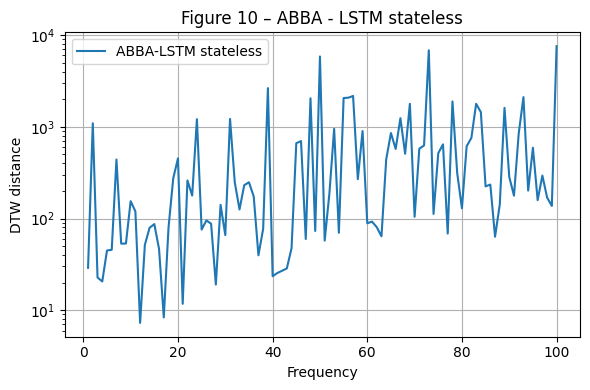

In [12]:
plt.figure(figsize=(6,4))
plt.plot(frequencies, dtw_abba, label="ABBA-LSTM stateless")
plt.xlabel("Frequency")
plt.yscale("log") 
plt.ylabel("DTW distance")
plt.title("Figure 10 – ABBA - LSTM stateless")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

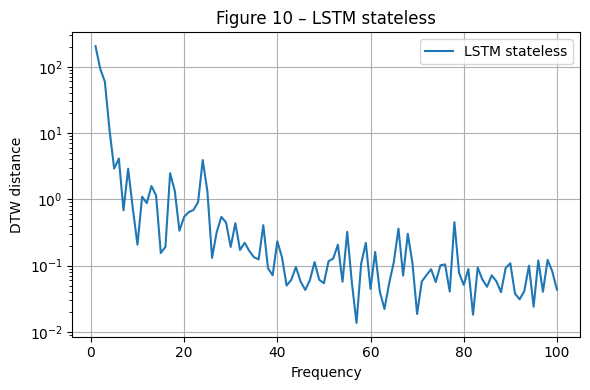

In [14]:
plt.figure(figsize=(6,4))
plt.plot(frequencies, dtw_lstm, label="LSTM stateless")
plt.xlabel("Frequency")
plt.yscale("log") 
plt.ylabel("DTW distance")
plt.title("Figure 10 – LSTM stateless")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 11

In [12]:
N = 200
lag = 20
p = 20
horizon = 100
n_runs = 5
series = np.array([t / N for t in range(N)], dtype=np.float32)
training = torch.tensor(series[:N // 2])
expected = series[N // 2:]
all_forecasts = []

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    torch.manual_seed(run)
    np.random.seed(run)
    lstm_model = TimeSeriesLSTM(lag=lag)
    train_lstm(
        lstm_model,
        training,
        patience=p
    )
    forecast = lstm_model.forecast(
        training[-lag:],
        horizon=horizon
    ).cpu().numpy()
    all_forecasts.append(forecast)

all_forecasts = np.array(all_forecasts)

Run 1/5
Epoch [10/200] Train: 0.009924 Val: 0.032602
Epoch [20/200] Train: 0.007284 Val: 0.061655
Early stopping à l'epoch 29 (best val loss = 0.032353)
Run 2/5
Epoch [10/200] Train: 0.010503 Val: 0.018622
Epoch [20/200] Train: 0.008017 Val: 0.068658
Epoch [30/200] Train: 0.006954 Val: 0.047460
Early stopping à l'epoch 30 (best val loss = 0.018622)
Run 3/5
Epoch [10/200] Train: 0.014638 Val: 0.020302
Epoch [20/200] Train: 0.006912 Val: 0.058749
Early stopping à l'epoch 29 (best val loss = 0.016243)
Run 4/5
Epoch [10/200] Train: 0.008884 Val: 0.021020
Epoch [20/200] Train: 0.007208 Val: 0.062108
Epoch [30/200] Train: 0.006435 Val: 0.042823
Early stopping à l'epoch 30 (best val loss = 0.021020)
Run 5/5
Epoch [10/200] Train: 0.012538 Val: 0.017646
Epoch [20/200] Train: 0.007934 Val: 0.068214
Epoch [30/200] Train: 0.007054 Val: 0.048686
Early stopping à l'epoch 30 (best val loss = 0.017646)


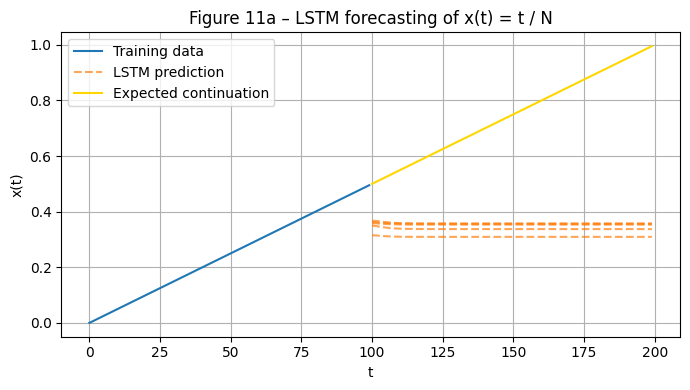

In [13]:
t_train = np.arange(len(training))
t_future = np.arange(len(training), N)

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    training.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    expected,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11a – LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
N = 200
lag = 3
p = 20
horizon = 100
n_runs = 5
series = [t / N for t in range(N)]
series = np.array(series) + 1e-2 * np.random.randn(len(series))
all_forecasts = []
training, expected = torch.tensor(series[:N // 2]), series[N // 2:]

for i in range(n_runs):
    abba = ABBAPatched(compression_tol=0.01, alpha=0.1, random_state=i)
    training_sym = abba.fit(training)
    abba_model = ABBALSTM(n_symbols=len(abba.patches.keys()),lag=lag)
    train_abba(abba_model, training_sym, patience=p)
    abba_forecast = abba_model.forecast(
        training_sym[-lag:],
        horizon=horizon
    )
    abba_forecast_num = abba.inverse_transform(abba_forecast, training[-1].item())
    abba_forecast_resampled = resample_to_horizon(
        abba_forecast_num,
        horizon
    )
    all_forecasts.append(abba_forecast_resampled)

Epoch [10/200] Train: 1.541924 Val: 1.582170
Epoch [20/200] Train: 1.223390 Val: 1.622364
Epoch [30/200] Train: 0.933945 Val: 1.839649
Early stopping à l'epoch 36 (best val loss = 1.547266)
Epoch [10/200] Train: 1.416392 Val: 1.606406
Epoch [20/200] Train: 1.208008 Val: 1.945683
Early stopping à l'epoch 29 (best val loss = 1.604453)
Epoch [10/200] Train: 1.464029 Val: 1.575409
Epoch [20/200] Train: 1.242196 Val: 1.740588
Epoch [30/200] Train: 1.163944 Val: 1.929611
Early stopping à l'epoch 32 (best val loss = 1.567766)
Epoch [10/200] Train: 1.470064 Val: 1.597364
Epoch [20/200] Train: 1.163793 Val: 1.724140
Epoch [30/200] Train: 0.949295 Val: 1.981412
Early stopping à l'epoch 33 (best val loss = 1.591829)
Epoch [10/200] Train: 1.437062 Val: 1.632882
Epoch [20/200] Train: 1.149146 Val: 1.850068
Epoch [30/200] Train: 0.914747 Val: 1.971589
Early stopping à l'epoch 31 (best val loss = 1.631436)


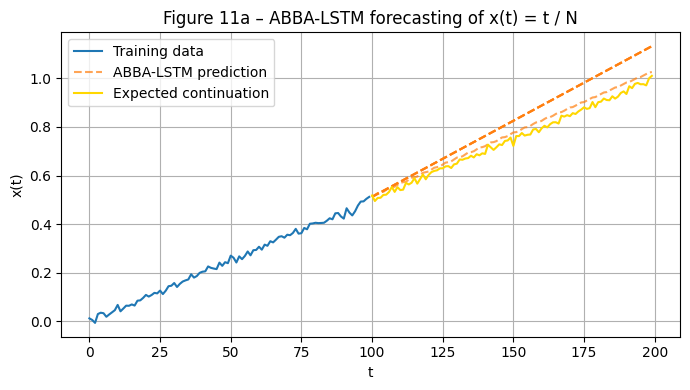

In [24]:
t_train = np.arange(len(training))
t_future = np.arange(len(training), N)

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    training.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    expected,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11a – ABBA-LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 12

In [3]:
ts = [349,349,347,351,347,347,347,347,351,348,348,347,349,347,348,346,347,347,347,347,346,346,351,346,349,348,349,352,347,352,347,347,347,345,349,347,348,346,348,348,351,346,347,118,347,118,118,117,119,120,120,117,117,117,117,120,120,120,119,119,119,121,118,121,120,120,119,120,3060,120,3025,3022,3048,3034,3048,3048,3099,3099,3099,3095,3019,3095,3095,3083,3019,3019,3027,3083,3083,3016,3016,3016,3016,122,118,122,122,118,118,118,120,253,120,120,241,235,242,234,233,234,228,233,229,233,231,231,231,235,231,232,229,231,229,232,229,232,231,232,225,229,225,225,228,225,225,228,231,230,230,228,230,231,228,228,228,233,225,225,225,224,225,224,225,223,227,223,225,227,225,229,227,229,225,228,225,227,225,228,228,225,222,221,222,394,392,391,391,391,391,392,392,380,378,380,374,374,374,381,374,374,381,379,371,379,379,379,377,371,372,372,376,376,371,372,372,374,371,372,380,379,374,374,374,376,374,372,376,375,375,375,375,376,372,376,372,372,372,375,372,377,375,372,374,370,374,378,370,378,378,378,378,378,378,379,378,378,375,375,375,369,371,369,371,375,371,371,376,375,370,370,369,370,370,370,369,372,369,366,374,369,374,372,369,372,395,413,395,395,425,421,424,424,423,421,425,419,421,421,421,431,421,419,423,419,419,423,423,421,420,421,423,423,421,423,421,424,423,416,424,422,416,416,426,419,426,419,426,422,422,422,422,416,424,416,426,417,422,417,417,417,417,419,416,415,416,416,422,416,416,424,412,417,412,417,426,412,423,414,414,423,416,423,416,415,419,415,419,414,421,414,414,417,417,415,417,411,420,411,417,415,420,420,419,414,419,419,414,416,413,413,415,415,414,413,411,416,411,413,411,413,415,412,415,410,411,410,412,410,412,417,411,408,408,412,408,408,411,410,412,413,414,412,410,412,409,416,409,411,415,411,411,414,417,414,414,412,419,412,409,412,409,409,411,412,411,411,412,416,412,412,413,416,417,413,416,416,416,409,413,416,416,416,408,419,408,416,408,416,413,411,413,411,411,411,406,410,406,408,416,408,409,411,416,416,408,409,410,415,410,410,405,405,412,416,412,413,411,413,408,415,408,404,414,404,405,405,412,411,411,411,411,408,404,411,411,405,408,405,405,405,403,409,403,410,406,410,406,406,406,406,403,412,403,402,406,402,408,402,408,403,404,403,409,406,404,405,408,404,408,408,408,404,405,405,405,405,406,405,403,412,403,406,409,406,409,405,409,409,409,405,405,405,409,409,410,409,402,410,404,410,403,405,405,409,403,409,409,408,405,408,411,406,411,399,394,399,399,404,403,404,408,404,408,406,404,410,409,402,409,409,404,401,408,401,401,401,401,405,399,405,405,403,403,403,403,411,406,411,265,268,265,268,266,268,264,267,264,264,270,268,265,265,267,265,265,267,267,266,272,272,274,264,274,274,266,268,268,268,266,273,266,268,269,268,268,272,276,272,267,267,267,270,2606,270,2514,2501,2606,2606,2486,2486,2520,2465,2520,2520,2468,2496,2496,2488,2488,2488,2488,2522,2488,2471,2475,2471,2517,2472,2517,2517,2495,2497,2471,2471,2543,2485,2543,2543,2543,2474,2485,2485,2474,2478,2474,2510,2510,2540,2516,2540,2477,2517,2477,2538,2538,2538,2538,2538,2538,2538,2475,2503,2475,2480,2533,2480,2480,2539,2483,2539,2539,2543,2474,2483,2543,2532,2532,2498,2532,2511,2498,2473,2511,2529,2529,2519,2529,2541,2519,364,2541,2541,364,364,364,364,364,364,364,359,364,364,364,360,359,359,2484,2474,2481,2481,2479,2474,2479,2517,2486,2472,2467,2471,2471,2467,2474,2484,2474,2484,359,363,359,359,359,363,363,358,360,358,358,363,367,363,363,363,363,2488,363,2483,2477,2488,2531,2477,2531,2528,2477,2479,2543,2479,2543,2542,361,2509,357,359,357,357,363,365,363,363,361,357,361,364,366,364,359,360,358,358,358,358,2475,2468,2483,2526,2468,2526,2479,2479,2479,361,2479,365,364,365,364,359,364,357,365,357,358,363,358,363,363,357,363,356,2544,363,2480,2497,2480,2460,2508,2513,2472,2508,2469,358,2477,357,365,357,360,360,360,357,358,357,357,357,357,358,357,358,359,361,359,359,2484,364,2472,364,2523,2472,2486,2523,2533,2498,2498,2476,2472,2476,2476,2476,366,360,360,360,360,364,358,364,364,365,361,365,365,363,363,363,363,363,361,360,361,356,356,360,360,356,357,356,2488,2515,2515,2537,2638,2537,2537,2638,2675,2642,2708,2708,519,521,519,519,522,517,522,522,521,524,521,521,524,522,524,517,518,523,534,523,534,551,542,548,567,567,2713,2708,2700,2713,2680,2700,2762,2698,2698,561,560,561,523,512,523,523,507,512,512,525,525,525,525,614,634,610,610,627,627,627,627,650,627,627,627,650,654,654,2865,654,654,2850,2865]

train = torch.tensor(ts[600:900], dtype=torch.float)
test = ts[900:1000]

In [4]:
N = len(train)
lag = 50
p = 10
horizon = len(test)
n_runs = 1
all_forecasts = []

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    torch.manual_seed(run)
    np.random.seed(run)
    lstm_model = TimeSeriesLSTM(lag=lag)
    train_lstm(
        lstm_model,
        train,
        patience=p
    )
    forecast = lstm_model.forecast(
        train[-lag:],
        horizon=horizon
    ).cpu().numpy()
    all_forecasts.append(forecast)

all_forecasts = np.array(all_forecasts)

Run 1/1


Epoch [10/200] Train: 4062836.083333 Val: 726727.125000
Epoch [20/200] Train: 4047766.500000 Val: 721968.687500
Epoch [30/200] Train: 4035927.770833 Val: 718146.375000
Epoch [40/200] Train: 4024851.520833 Val: 714570.375000
Epoch [50/200] Train: 4014128.104167 Val: 711117.937500
Epoch [60/200] Train: 4003617.979167 Val: 707744.875000
Epoch [70/200] Train: 3993254.979167 Val: 704430.875000
Epoch [80/200] Train: 3983002.750000 Val: 701163.812500
Epoch [90/200] Train: 3972838.833333 Val: 697936.875000
Epoch [100/200] Train: 3962748.500000 Val: 694745.000000
Epoch [110/200] Train: 3952721.104167 Val: 691584.875000
Epoch [120/200] Train: 3942749.291667 Val: 688453.875000
Epoch [130/200] Train: 3932827.437500 Val: 685350.437500
Epoch [140/200] Train: 3922951.000000 Val: 682272.750000
Epoch [150/200] Train: 3913117.020833 Val: 679219.875000
Epoch [160/200] Train: 3903322.000000 Val: 676191.000000
Epoch [170/200] Train: 3893564.291667 Val: 673185.000000
Epoch [180/200] Train: 3883841.312500 Va

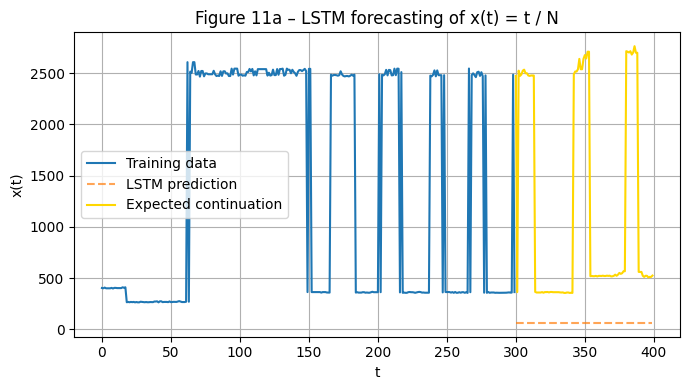

In [5]:
t_train = np.arange(len(train))
t_future = np.arange(N, N + len(test))

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    train.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    test,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11a – LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
N = len(train)
lag = 3
p = 10
horizon = len(test)
n_runs = 1
all_forecasts = []

for i in range(n_runs):
    abba = ABBAPatched(compression_tol=2000, alpha=120, random_state=i)
    training_sym = abba.fit(train)
    abba_model = ABBALSTM(n_symbols=len(abba.patches.keys()),lag=lag)
    train_abba(abba_model, training_sym, epochs=2000, lr=0.0001, patience=p)
    abba_forecast = abba_model.forecast(
        training_sym[-lag:],
        horizon=horizon
    )
    abba_forecast_num = abba.inverse_transform(abba_forecast, train[-1].item())
    abba_forecast_resampled = resample_to_horizon(
        abba_forecast_num,
        horizon
    )
    all_forecasts.append(abba_forecast_resampled)

Epoch [10/2000] Train: 1.640752 Val: 1.653594
Epoch [20/2000] Train: 1.629511 Val: 1.639690
Epoch [30/2000] Train: 1.618346 Val: 1.625899
Epoch [40/2000] Train: 1.607006 Val: 1.611886
Epoch [50/2000] Train: 1.595214 Val: 1.597272
Epoch [60/2000] Train: 1.582671 Val: 1.581669
Epoch [70/2000] Train: 1.569046 Val: 1.564644
Epoch [80/2000] Train: 1.553954 Val: 1.545698
Epoch [90/2000] Train: 1.536933 Val: 1.524234
Epoch [100/2000] Train: 1.517424 Val: 1.499532
Epoch [110/2000] Train: 1.494748 Val: 1.470722
Epoch [120/2000] Train: 1.468102 Val: 1.436782
Epoch [130/2000] Train: 1.436591 Val: 1.396588
Epoch [140/2000] Train: 1.399301 Val: 1.349036
Epoch [150/2000] Train: 1.355486 Val: 1.293293
Epoch [160/2000] Train: 1.304863 Val: 1.229221
Epoch [170/2000] Train: 1.248055 Val: 1.157948
Epoch [180/2000] Train: 1.186998 Val: 1.082361
Epoch [190/2000] Train: 1.125034 Val: 1.007081
Epoch [200/2000] Train: 1.066294 Val: 0.937510
Epoch [210/2000] Train: 1.014454 Val: 0.878133
Epoch [220/2000] Train

In [12]:
abba = ABBAPatched(compression_tol=2000, alpha=120)
training_sym = abba.fit(train)
n_symbols = len(abba.patches)
print(f"tol={tol:.4f}, alpha={alpha:.2f} -> {n_symbols} symboles")

tol=2422.8400, alpha=65.27 -> 5 symboles


In [10]:
target_symbols = (1, 5)
tol = 0.01  # valeur de départ
alpha = 0.1
max_iter = 500

for _ in range(max_iter):
    abba = ABBAPatched(compression_tol=tol, alpha=alpha)
    training_sym = abba.fit(train)
    n_symbols = len(abba.patches)
    print(f"tol={tol:.4f}, alpha={alpha:.2f} -> {n_symbols} symboles")

    if target_symbols[0] <= n_symbols <= target_symbols[1]:
        break
    elif n_symbols < target_symbols[0]:
        tol *= 0.8  # segments trop gros, on diminue tol
        alpha *= 0.9
    else:
        tol *= 1.2  # segments trop petits, on augmente tol
        alpha *= 1.1


tol=0.0100, alpha=0.10 -> 102 symboles
tol=0.0120, alpha=0.11 -> 102 symboles
tol=0.0144, alpha=0.12 -> 102 symboles
tol=0.0173, alpha=0.13 -> 102 symboles


tol=0.0207, alpha=0.15 -> 102 symboles
tol=0.0249, alpha=0.16 -> 102 symboles
tol=0.0299, alpha=0.18 -> 102 symboles
tol=0.0358, alpha=0.19 -> 102 symboles
tol=0.0430, alpha=0.21 -> 102 symboles
tol=0.0516, alpha=0.24 -> 102 symboles
tol=0.0619, alpha=0.26 -> 102 symboles
tol=0.0743, alpha=0.29 -> 102 symboles
tol=0.0892, alpha=0.31 -> 102 symboles
tol=0.1070, alpha=0.35 -> 102 symboles
tol=0.1284, alpha=0.38 -> 102 symboles
tol=0.1541, alpha=0.42 -> 102 symboles
tol=0.1849, alpha=0.46 -> 102 symboles
tol=0.2219, alpha=0.51 -> 102 symboles
tol=0.2662, alpha=0.56 -> 102 symboles
tol=0.3195, alpha=0.61 -> 102 symboles
tol=0.3834, alpha=0.67 -> 102 symboles
tol=0.4601, alpha=0.74 -> 102 symboles
tol=0.5521, alpha=0.81 -> 108 symboles
tol=0.6625, alpha=0.90 -> 108 symboles
tol=0.7950, alpha=0.98 -> 109 symboles
tol=0.9540, alpha=1.08 -> 81 symboles
tol=1.1448, alpha=1.19 -> 81 symboles
tol=1.3737, alpha=1.31 -> 80 symboles
tol=1.6484, alpha=1.44 -> 79 symboles
tol=1.9781, alpha=1.59 -> 75 

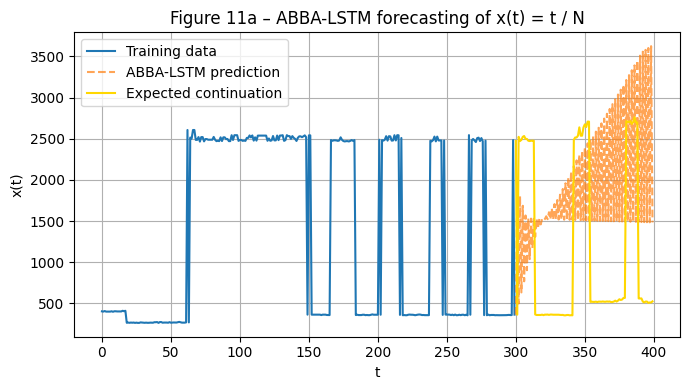

In [18]:
t_train = np.arange(len(train))
t_future = np.arange(N, N + len(test))

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    train.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    test,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11a – ABBA-LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
training_sym

array([0, 1, 2, 1, 3, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4])

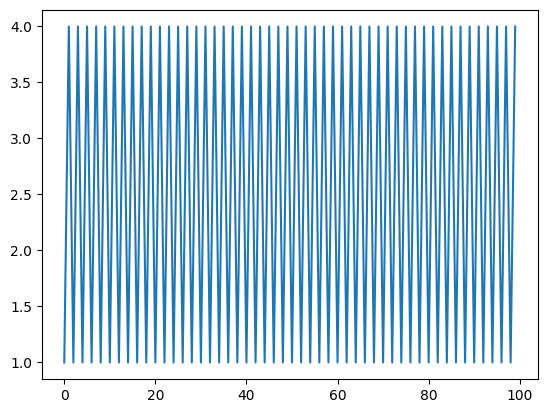

In [20]:
plt.plot(abba_forecast)